##  Orthologs in S. cerevisiae, S. pombe + conservation score based on 9 species

**Input**: 
* cerevisiae: Orthologs from ENSEMBL, essentiality from OGEE
* pombe: Orthologs from PomBase, essentiality from Kim et al.
* conservation score: orthologs from ENSEMBL & InParanoid

**Output**: Paralog pairs annotated with ortholog features

NOTE: Treating lack of essentiality data as 'has non-essential ortholog'

Single essential ortholog => single ortholog in yeast (i.e. no yeast duplicates), so 1 yeast gene for the human paralogs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 12, 'axes.spines.top': False, 'axes.spines.right': False, 'axes.axisbelow': True})

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_unique_pairs = get_local_data_path(['processed', 'ensembl93'], 'unique_pairs.csv')
file_cerevisiae_orthologs = get_data_path(['ensembl', '93'], 'cerevisiae_orthologs.txt')
file_cerevisiae_essentiality = get_data_path(['OGEE'], 'gene_essentiality.txt.gz')
file_pombe_orthologs = get_data_path(['pombase'], 'pombase-2020-07-02.human-orthologs.txt.gz')
file_pombe_deletions = get_data_path(['kim_2010'], 'pombe_gene_deletions.xls')

file_species_orthologs = get_data_path(['ensembl','93'], 'six_species_orthologs.txt')
file_uniprot_ids = get_data_path(['ensembl','93'], 'paralog_uniprot_ids.txt') # For InParanoid data
file_IP_thaliana = get_data_path(['InParanoid','A.thaliana'], 'sqltable.A.thaliana-H.sapiens')
file_IP_ecoli = get_data_path(['InParanoid','E.coli'], 'sqltable.E.coli-H.sapiens')

# Ouput
file_ortholog_features = get_local_data_path(['processed','paralog_features'], 'ortholog_features.csv')

In [2]:
pairs = pd.read_csv(file_unique_pairs, index_col=0)
print('Num pairs:', pairs.shape[0], ', num genes:', pd.concat([pairs.A1_ensembl, pairs.A2_ensembl]).nunique())
pairs[:1]

Num pairs: 36648 , num genes: 13320


,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,cds_length_ratio,A1_entrez,A1_ensembl,A2_entrez,A2_ensembl
0,A1BG,OSCAR,0.127273,0.22028,False,False,False,True,False,3,0.578629,1,ENSG00000121410,126014,ENSG00000170909


In [4]:
# For data from InParanoid - see below
uniprot_ids = pd.read_csv(file_uniprot_ids).dropna()
display(uniprot_ids[:1])
uniprot_ids.columns = ['ensembl_id', 'protein_id']
uniprot_ids[:1]

,Gene stable ID,UniProtKB Gene Name ID
3,ENSG00000013503,F8VRU2


,ensembl_id,protein_id
3,ENSG00000013503,F8VRU2


In [5]:
def read_paranoid_file(fname, species, cutoff=0.5):
    inparanoid = pd.read_csv(fname, sep='\t', header=None)
    inparanoid.columns = ['cluster', 'unknown', 'species', 'score', 'protein_id', 'bootstrap']
    inparanoid = pd.merge(inparanoid, uniprot_ids)
    inparanoid = inparanoid[inparanoid.score >= cutoff].groupby('ensembl_id').cluster.count().reset_index()
    inparanoid = inparanoid.rename(columns={'cluster':species})
    return inparanoid

### S. cerevisiae orthologs

2 boolean features:
* has cerevisiae ortholog
* has essential cerevisiae ortholog

In [6]:
c_ortho = pd.read_csv(file_cerevisiae_orthologs).dropna()
c_ortho = c_ortho.rename(columns={'Gene stable ID':'ensembl_id',
                                  'Saccharomyces cerevisiae gene stable ID':'cerevisiae_id',
                                  'Saccharomyces cerevisiae homology type':'homology_type'})
print('Cerevisiae orthologs:', c_ortho['cerevisiae_id'].nunique())
display(c_ortho[:1])

# Call essential if essential in at least 1 study
# e.g. E & NE: http://ogee.medgenius.info/browse/Saccharomyces%2520cerevisiae/YKL122C
c_ess = pd.read_csv(file_cerevisiae_essentiality, sep='\t')
c_ess = c_ess[c_ess.sciName == 'Saccharomyces cerevisiae'].reset_index(drop=True)
display(c_ess[:1])
c_ess['essential'] = c_ess.essential =='E'
c_ess = c_ess.groupby('locus').essential.max().reset_index()
display(c_ess[:1])

Cerevisiae orthologs: 1146


,ensembl_id,cerevisiae_id,homology_type
3,ENSG00000013503,YOR207C,ortholog_one2many


,sciName,kingdom,datasetID,locus,essential,pubmedID,taxID,thumbup,thumbdown,valid,fitnessScore,id
0,Saccharomyces cerevisiae,eukaryota,350,Q0045,NE,0,4932,0,0,0,-1.0,3834


,locus,essential
0,Q0045,False


In [7]:
# Merge essentiality info with orthologs
df = pd.merge(c_ortho[['ensembl_id', 'cerevisiae_id', 'homology_type']], 
              c_ess.rename(columns={'locus':'cerevisiae_id'}))

# Homology types for essential orthologs
print(df[df.essential].drop_duplicates(subset=['cerevisiae_id'])['homology_type'].value_counts())

# Assign features to each paralog pair
cerevisiae_features = pairs[['A1','A2']].assign(
    has_cerevisiae_ortholog = 
        (pairs.A1_ensembl.isin(df.ensembl_id) | pairs.A2_ensembl.isin(df.ensembl_id)),
    has_essential_cerevisiae_ortholog = 
        (pairs.A1_ensembl.isin(df[df.essential].ensembl_id) | pairs.A2_ensembl.isin(df[df.essential].ensembl_id)),
    has_single_essential_cerevisiae_ortholog = 
        (pairs.A1_ensembl.isin(df[df.essential & (df.homology_type!='ortholog_many2many')].ensembl_id) | 
         pairs.A2_ensembl.isin(df[df.essential & (df.homology_type!='ortholog_many2many')].ensembl_id))
)

print('\nPairs w/ single / essential / cerevisiae ortholog:', 
      cerevisiae_features[cerevisiae_features.has_single_essential_cerevisiae_ortholog].shape[0], '/',
      cerevisiae_features[cerevisiae_features.has_essential_cerevisiae_ortholog].shape[0], '/',
      cerevisiae_features[cerevisiae_features.has_cerevisiae_ortholog].shape[0])
cerevisiae_features[:2]

ortholog_one2many     253
ortholog_many2many     17
ortholog_one2one        1
Name: homology_type, dtype: int64

Pairs w/ single / essential / cerevisiae ortholog: 2035 / 2430 / 8172


,A1,A2,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog
0,A1BG,OSCAR,False,False,False
1,A1BG,TARM1,False,False,False


### S. pombe orthologs

In [8]:
p_ortho = pd.read_csv(file_pombe_orthologs, sep='\t', header=None)
p_ortho = p_ortho.rename(columns={0:'pombe_id', 1:'symbol'})
p_ortho = p_ortho[p_ortho.symbol != 'NONE'].reset_index(drop=True)
display(p_ortho[2:3])

# Expand human genes, they are delimited with | (=multiple orthologs for a pombe gene, one2many)
df = p_ortho.set_index('pombe_id').symbol.apply(lambda x: pd.Series(x.split('|'))).stack()\
            .reset_index().drop(columns=['level_1']).rename(columns={0:'symbol'})
assert(p_ortho.shape[0] + p_ortho.symbol.apply(lambda x: x.count('|')).sum() == df.shape[0])
p_ortho = df
display(p_ortho[2:4])

,pombe_id,symbol
2,SPAC1002.05c,KDM5D|KDM5C|KDM5B|KDM5A


,pombe_id,symbol
2,SPAC1002.05c,KDM5D
3,SPAC1002.05c,KDM5C


In [9]:
# E = essential, V = viable (not essential) in Analysis dataset column
p_ess = pd.read_excel(file_pombe_deletions)
p_ess = p_ess.rename(columns={'Analysis dataset':'essentiality', 'Systemic ID':'pombe_id'})
p_ess = p_ess[['pombe_id', 'essentiality']].dropna(subset=['essentiality'])
p_ess['essential'] = p_ess.essentiality=='E'
display(p_ess[:1])

# Merge essentiality info with orthologs
pombe_df = pd.merge(p_ortho, p_ess[['pombe_id','essential']], how='left').fillna({'essential':False})
print('N. essential pombe genes:', pombe_df[pombe_df.essential].pombe_id.nunique(), '/', pombe_df.pombe_id.nunique())
display(pombe_df[:2])

,pombe_id,essentiality,essential
0,SPAC1002.01,V,False


N. essential pombe genes: 1116 / 3534


,pombe_id,symbol,essential
0,SPAC1002.03c,GANAB,False
1,SPAC1002.04c,TAF11,True


In [10]:
# Merge pombe info with paralog pairs (independently for each gene)
df1 = pd.merge(pairs[['A1','A2']], pombe_df.rename(columns={'symbol':'A1'}))
df2 = pd.merge(pairs[['A1','A2']], pombe_df.rename(columns={'symbol':'A2'}))
df = pd.concat([df1,df2]).drop_duplicates()

# Count # of pombe genes per human gene and whether at least 1 pombe ortholog is essential
# pombe_id > 1 implies 'many2many' otherwise 'one2many'
df = df.groupby(['A1','A2']).agg({'pombe_id':'nunique', 'essential':'max'}).reset_index()
display(df[:1])
print('One2many:', df[df.essential & (df.pombe_id==1)].shape[0])
print('Many2many:', df[df.essential & (df.pombe_id>1)].shape[0])

# Assign features to each paralog pair
pombe_features = pd.merge(pairs[['A1','A2']], df, how='left').fillna({'pombe_id':0})
pombe_features['has_pombe_ortholog'] = pombe_features.pombe_id != 0
pombe_features['has_essential_pombe_ortholog'] = pombe_features.essential==True
pombe_features['has_single_essential_pombe_ortholog'] = ((pombe_features.pombe_id == 1) & (pombe_features.essential==True))
pombe_features = pombe_features.drop(columns=['pombe_id', 'essential'])

print('\nPairs w/ single / essential / pombe ortholog:', 
      sum(pombe_features.has_single_essential_pombe_ortholog), '/', 
      sum(pombe_features.has_essential_pombe_ortholog), '/', 
      sum(pombe_features.has_pombe_ortholog))
pombe_features[:2]

,A1,A2,pombe_id,essential
0,AADAC,AADACL2,1,False


One2many: 1062
Many2many: 605

Pairs w/ single / essential / pombe ortholog: 1062 / 1667 / 5757


,A1,A2,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog
0,A1BG,OSCAR,False,False,False
1,A1BG,TARM1,False,False,False


### Conservation score

Based on orthologs from 9 species:
- S. cerevisiae
- Drosophila (fruitfly)
- Mouse
- C. elegans
- Zebrafish
- Xenopus (tropical clawed frog)
- Rat
- Thale cress (InParanoid)
- E. coli (InParanoid)

In [12]:
species_orthologs_raw = pd.read_csv(file_species_orthologs)
species_orthologs_raw[1:2]

,Gene stable ID,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID
1,ENSG00000276345,WBGene00020348,FBgn0035335,ENSMUSG00000037772,ENSRNOG00000020354,ENSXETG00000014017,ENSDARG00000045696


In [14]:
orthologs = species_orthologs_raw.groupby('Gene stable ID').agg(lambda x: ~x.isna().all()).reset_index()

# Add cerevisiae orthologs 
cerevisiae = pd.read_csv(file_cerevisiae_orthologs)[['Gene stable ID', 'Saccharomyces cerevisiae gene stable ID']]
cerevisiae = cerevisiae.groupby('Gene stable ID').agg(lambda x: ~x.isna().all()).reset_index()
orthologs = pd.merge(orthologs, cerevisiae, how="outer").rename(columns={'Gene stable ID':'ensembl_id'})
display(orthologs[:1])

# Add E. coli and thale cress orthologs from InParanoid
thale_cress = read_paranoid_file(file_IP_thaliana, 'thale_cress')
ecoli = read_paranoid_file(file_IP_ecoli, 'e_coli')
orthologs = pd.merge(orthologs, thale_cress, how="outer")
orthologs = pd.merge(orthologs, ecoli, how="outer")
orthologs = orthologs.assign(thale_cress = ~orthologs.thale_cress.isna(), e_coli = ~orthologs.e_coli.isna())

,ensembl_id,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID,Saccharomyces cerevisiae gene stable ID
0,ENSG00000000003,False,False,True,True,True,True,False


In [15]:
n_species = orthologs.shape[1]-1
display(orthologs[:1])
print('N genes with orthologs:', orthologs.shape[0])
print('N species:', n_species)

,ensembl_id,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID,Saccharomyces cerevisiae gene stable ID,thale_cress,e_coli
0,ENSG00000000003,False,False,True,True,True,True,False,False,False


N genes with orthologs: 14532
N species: 9


In [16]:
# Conversation score = number of species in which at least one paralog has an ortholog
df1 = pd.merge(pairs[['A1_ensembl','A2_ensembl']], orthologs.rename(columns={'ensembl_id':'A1_ensembl'}))
df2 = pd.merge(pairs[['A1_ensembl','A2_ensembl']], orthologs.rename(columns={'ensembl_id':'A2_ensembl'}))
df = pd.concat([df1, df2])

# Indicates whether either gene has an ortholog in each species
df = df.groupby(['A1_ensembl','A2_ensembl']).max().reset_index()
display(df[:1])

df['conservation_score'] = df.iloc[:, 2:].sum(axis=1)
conservation = df[['A1_ensembl','A2_ensembl','conservation_score']]
print('Pairs conserved in all 9 species:', conservation[conservation.conservation_score==9].shape[0])
display(conservation[:1])

,A1_ensembl,A2_ensembl,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID,Saccharomyces cerevisiae gene stable ID,thale_cress,e_coli
0,ENSG00000000003,ENSG00000156298,False,False,True,True,True,True,False,False,False


Pairs conserved in all 9 species: 260


,A1_ensembl,A2_ensembl,conservation_score
0,ENSG00000000003,ENSG00000156298,4


### Merge and export

In [23]:
ortholog_features = pd.merge(pairs[['A1','A2','A1_ensembl','A2_ensembl']], cerevisiae_features)
ortholog_features = pd.merge(ortholog_features, pombe_features)
ortholog_features = pd.merge(ortholog_features, conservation)
assert(ortholog_features.shape[0] == pairs.shape[0])
ortholog_features[:1]

,A1,A2,A1_ensembl,A2_ensembl,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score
0,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,False,False,False,False,False,False,3


In [24]:
ortholog_features.to_csv(file_ortholog_features, index=0)

### Visualization - distribution

<AxesSubplot:xlabel='conservation_score', ylabel='count'>

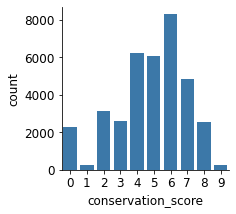

In [25]:
f, ax = plt.subplots(1, 1, figsize=(3,3))
sns.countplot(ortholog_features.conservation_score, ax=ax, color=sns.color_palette('Blues')[4])